# M5 Data Preparation

This notebook helps with loading and transforming the M5 dataset into higher-level, aggregate time series. M5, by default, is provided as a set of 30,490 individual time series. These correspond to individual product sales figures at individual Walmart stores. These time series can be naturally aggregated according to a hierarchy: 

<img src="https://www.artefact.com//wp-content/uploads/2021/03/Image-1-.png"/>

As we can see, the 30,490 time series correspond to sales figures for 3049 individual products across 10 stores. The products each belong to one of three product categories (Hobbies, Foods, and Household), which can be further broken down into a total of 7 product subcategories. The 10 stores each belong to one of three states (California, Texas, and Wisconsin). 

Other information are also provided as part of the M5 dataset, including product sell prices and a calendar of important events (e.g. holidays, relevant dates for [nutrition assistance programs](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133614)).

The following code has been adapted from this [repository](https://github.com/matthiasanderer/m5-accuracy-competition) for the official 2nd place M5 solution.

## Load data

In [18]:
from typing import Union
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from datetime import timedelta
import datetime 
from tqdm import tqdm
tqdm.pandas()


%matplotlib inline
pd.set_option('display.max_columns', None)



In [21]:
timestring = lambda : datetime.datetime.now().strftime("%H_%M_%S")

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam

In [6]:


import m5_helpers
import m5_models
import nbeats

%matplotlib inline


ModuleNotFoundError: No module named 'nbeats'

In [7]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
sell_price = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
train = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv').set_index('id')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

In [8]:
train.head(10)

item_id    dept_id   cat_id store_id  \
id                                                                          
HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_006_CA_1_evaluation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_007_CA_1_evaluation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_009_CA_1_evaluation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_010_CA_1_evaluation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   

                              state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  \
id                                                                          
HOBBIES_1_001_CA_1_evaluation       CA    0    0    0    0    0    0    0   
HOBBIES_1_002_CA_1_evaluation       CA    0    0    0    0    0    0    0   
HOBBIES_1_003_CA_1_evaluation       CA    0    0    0    0    0    0    0   
HOBBIES_1_004_CA_1_evaluation       CA    0    0    0    0    0    0    0   
HOBBIES_1_005_CA_1_evaluation       CA    0    0    0    0    0    0    0   
HOBBIES_1_006_CA_1_evaluation       CA    0    0    0    0    0    0    0   
HOBBIES_1_007_CA_1_evaluation       CA    0    0    0    0    0    0    0   
HOBBIES_1_008_CA_1_evaluation       CA   12   15    0    0    0    4    6   
HOBBIES_1_009_CA_1_evaluation       CA    2    0    7    3    0    2    3   
HOBBIES_1_010_CA_1_evaluation       CA    0    0    1    0    0    0    0   

                               d_8  d_9  d_10  d_11  d_12  d_13  d_14  d_15  \
id                                                                            
HOBBIES_1_001_CA_1_evaluation    0    0     0     0     0     0     0     0   
HOBBIES_1_002_CA_1_evaluation    0    0     0     0     0     0     0     0   
HOBBIES_1_003_CA_1_evaluation    0    0     0     0     0     0     0     0   
HOBBIES_1_004_CA_1_evaluation    0    0     0     0     0     0     0     0   
HOBBIES_1_005_CA_1_evaluation    0    0     0     0     0     0     0     0   
HOBBIES_1_006_CA_1_evaluation    0    0     0     0     0     0     0     0   
HOBBIES_1_007_CA_1_evaluation    0    0     0     0     0     0     0     0   
HOBBIES_1_008_CA_1_evaluation    5    7     0    13     2     2    20     9   
HOBBIES_1_009_CA_1_evaluation    9    0     0     4     3     1     0     4   
HOBBIES_1_010_CA_1_evaluation    0    0     0     0     0     0     2     0   

                               d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  \
id                                                                              
HOBBIES_1_001_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_002_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_003_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_004_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_005_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_006_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_007_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_008_CA_1_evaluation     3     0     1     0     0     0    10     4   
HOBBIES_1_009_CA_1_evaluation     4     1     2     0     1     1     5     2   
HOBBIES_1_010_CA_1_evaluation     0     0     0     2     0     0     0     1   

                               d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  \
id                                                                              
HOBBIES_1_001_CA_1_evaluation     0     0     0     0     0     0     0     0   
HOBBIES_1_002_CA_1_eva

In [9]:
sell_price.info()
calendar.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       19

In [12]:
train_fold_df = train.iloc[:, :-28]
valid_fold_df = train.iloc[:, -28:]

valid_fold_df.head(10)
e = m5_helpers.WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar,sell_price)

100%|██████████| 42840/42840 [00:04<00:00, 9108.30it/s]


In [14]:
# Use this is you want to fit on the full 42840 sequences
df_train = e.train_series
df_valid = e.valid_series
df = pd.concat([df_train, df_valid], axis=1)
df = df.reset_index().rename(columns={'index':'id'})

In [15]:
df_train.head(10)

0      1      2      3      4      5      6      7      8      9     \
all   32631  31749  23783  25412  19146  29211  28010  37932  32736  25572   
CA    14195  13805  10108  11047   9925  11322  12251  16610  14696  11822   
TX     9438   9630   6778   7381   5912   9006   6226   9440   9376   7319   
WI     8998   8314   6897   6984   3309   8883   9533  11882   8664   6431   
CA_1   4337   4155   2816   3051   2630   3276   3450   5437   4340   3157   
CA_2   3494   3046   2121   2324   1942   2288   2629   3729   2957   2218   
CA_3   4739   4827   3785   4232   3817   4369   4703   5456   5581   4912   
CA_4   1625   1777   1386   1440   1536   1389   1469   1988   1818   1535   
TX_1   2556   2687   1822   2258   1694   2734   1691   2820   2887   2174   
TX_2   3852   3937   2731   2954   2492   3439   2588   3772   3657   2932   

       10     11     12     13     14     15     16     17     18     19    \
all   23071  23658  23756  26445  34833  36380  21804  24070  21443  20318   
CA    10933  10350  11204  11354  14610  15630   9044   9496   8844   7835   
TX     6224   6740   6109   7202  10081  11725   6719   7460   6606   6412   
WI     5914   6568   6443   7889  10142   9025   6041   7114   5993   6071   
CA_1   2995   2710   2928   3078   4316   4354   2757   2430   2272   2009   
CA_2   2123   1901   2436   2584   3455   3563   1801   1797   1741   1614   
CA_3   4447   4544   4406   4380   5187   5780   3303   3758   3641   3099   
CA_4   1368   1195   1434   1312   1652   1933   1183   1511   1190   1113   
TX_1   1607   2149   1895   2256   2944   3432   1921   2217   1962   1821   
TX_2   2628   2669   2515   2883   4000   4779   2679   2927   2606   2449   

       20     21     22     23     24     25     26     27     28     29    \
all   23721  31689  29283  23966  20501  20757  20277  22529  29908  28707   
CA    10025  13870  13465  11997   9130   8941   8514   9847  13652  12491   
TX     6711   9150   9789   7297   6628   5814   6175   6286   8586   9086   
WI     6985   8669   6029   4672   4743   6002   5588   6396   7670   7130   
CA_1   3015   4553   3966   3264   2441   2377   2414   2701   3719   3548   
CA_2   2214   3080   3087   2601   1810   1851   1652   2187   3516   2692   
CA_3   3320   4694   4794   4631   3593   3342   3310   3575   4774   4540   
CA_4   1476   1543   1618   1501   1286   1371   1138   1384   1643   1711   
TX_1   1951   2571   2810   2071   1933   1723   1825   1886   2629   2688   
TX_2   2615   3705   3845   3006   2725   2268   2488   2506   3565   3660   

       30     31     32     33     34     35     36     37     38     39    \
all   21240  22872  22046  23475  23572  31202  34876  24562  22752  22560   
CA     9196   9782   9537   9710  10444  13784  16057  10953  10299   9951   
TX     6555   7082   6145   6639   6584   9238  10423   7623   6335   6941   
WI     5489   6008   6364   7126   6544   8180   8396   5986   6118   5668   
CA_1   2246   2549   2559   2568   2978   4096   4832   3138   2997   2772   
CA_2   1894   1958   1837   2010   2105   3199   3272   1970   1800   2064   
CA_3   3604   3846   3821   3757   3904   4894   5895   4274   4084   3754   
CA_4   1452   1429   1320   1375   1457   1595   2058   1571   1418   1361   
TX_1   1985   1967   1860   2052   1753   2642   3031   2272   1788   2180   
TX_2   2548   3023   2383   2545   2718   3627   4379   2954   2495   2705   

       40     41     42     43     44     45     46     47     48     49    \
all   22626  25572  32225  31417  24935  24021  22765  21779  23855  30599   
CA    10012  11189  13710  14340  10722   9293   9752   9504  10030  14509   
TX     6339   7203   9271   9542   7745   7834   6768   6759   7131   8203   
WI     6275   7180   9244   7535   6468   6894   6245   5516   6694   7887   
CA_1   2650   3249   4114   4094   2880   2384   2522   2435   2744   4142   
CA_2   2041   2375   3114   3224   2044   1969   2082   2234   2227   3554   
CA_3   3898   4108   4823

In [16]:
df.head(10)

id      0      1      2      3      4      5      6      7      8      9  \
0   all  32631  31749  23783  25412  19146  29211  28010  37932  32736  25572   
1    CA  14195  13805  10108  11047   9925  11322  12251  16610  14696  11822   
2    TX   9438   9630   6778   7381   5912   9006   6226   9440   9376   7319   
3    WI   8998   8314   6897   6984   3309   8883   9533  11882   8664   6431   
4  CA_1   4337   4155   2816   3051   2630   3276   3450   5437   4340   3157   
5  CA_2   3494   3046   2121   2324   1942   2288   2629   3729   2957   2218   
6  CA_3   4739   4827   3785   4232   3817   4369   4703   5456   5581   4912   
7  CA_4   1625   1777   1386   1440   1536   1389   1469   1988   1818   1535   
8  TX_1   2556   2687   1822   2258   1694   2734   1691   2820   2887   2174   
9  TX_2   3852   3937   2731   2954   2492   3439   2588   3772   3657   2932   

      10     11     12     13     14     15     16     17     18     19  \
0  23071  23658  23756  26445  34833  36380  21804  24070  21443  20318   
1  10933  10350  11204  11354  14610  15630   9044   9496   8844   7835   
2   6224   6740   6109   7202  10081  11725   6719   7460   6606   6412   
3   5914   6568   6443   7889  10142   9025   6041   7114   5993   6071   
4   2995   2710   2928   3078   4316   4354   2757   2430   2272   2009   
5   2123   1901   2436   2584   3455   3563   1801   1797   1741   1614   
6   4447   4544   4406   4380   5187   5780   3303   3758   3641   3099   
7   1368   1195   1434   1312   1652   1933   1183   1511   1190   1113   
8   1607   2149   1895   2256   2944   3432   1921   2217   1962   1821   
9   2628   2669   2515   2883   4000   4779   2679   2927   2606   2449   

      20     21     22     23     24     25     26     27     28     29  \
0  23721  31689  29283  23966  20501  20757  20277  22529  29908  28707   
1  10025  13870  13465  11997   9130   8941   8514   9847  13652  12491   
2   6711   9150   9789   7297   6628   5814   6175   6286   8586   9086   
3   6985   8669   6029   4672   4743   6002   5588   6396   7670   7130   
4   3015   4553   3966   3264   2441   2377   2414   2701   3719   3548   
5   2214   3080   3087   2601   1810   1851   1652   2187   3516   2692   
6   3320   4694   4794   4631   3593   3342   3310   3575   4774   4540   
7   1476   1543   1618   1501   1286   1371   1138   1384   1643   1711   
8   1951   2571   2810   2071   1933   1723   1825   1886   2629   2688   
9   2615   3705   3845   3006   2725   2268   2488   2506   3565   3660   

      30     31     32     33     34     35     36     37     38     39  \
0  21240  22872  22046  23475  23572  31202  34876  24562  22752  22560   
1   9196   9782   9537   9710  10444  13784  16057  10953  10299   9951   
2   6555   7082   6145   6639   6584   9238  10423   7623   6335   6941   
3   5489   6008   6364   7126   6544   8180   8396   5986   6118   5668   
4   2246   2549   2559   2568   2978   4096   4832   3138   2997   2772   
5   1894   1958   1837   2010   2105   3199   3272   1970   1800   2064   
6   3604   3846   3821   3757   3904   4894   5895   4274   4084   3754   
7   1452   1429   1320   1375   1457   1595   2058   1571   1418   1361   
8   1985   1967   1860   2052   1753   2642   3031   2272   1788   2180   
9   2548   3023   2383   2545   2718   3627   4379   2954   2495   2705   

      40     41     42     43     44     45     46     47     48     49  \
0  22626  25572  32225  31417  24935  24021  22765  21779  23855  30599   
1  10012  11189  13710  14340  10722   9293   9752   9504  10030  14509   
2   6339   7203   9271   9542   7745   7834   6768   6759   7131   8203   
3   6275   7180   9244   7535   6468   6894   6245   5516   6694   7887   
4   2650   3249   4114   4094   2880   2384   2522   2435   2744   4142   
5   2041   2375   3114   3224   2044   1969   2082   2234   2227   3554   
6   3898   4108   4823   5342   4231   3624   3767   3653   3562   5235   
7   1423   1457   1659   1680   156

In [25]:
import datetime 

length = len(df.columns)-1
start_day = datetime.datetime.strptime('2011-01-29', '%Y-%m-%d')
date_list = [(start_day + datetime.timedelta(days=x)).date() for x in range(length)]
df.columns = [df.columns[0]]+date_list
data_start_date = df.columns[1]
data_end_date = df.columns[-1]

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]), data=[i for i in range(len(df.columns[1:]))])

print('Data ranges from %s to %s' % (data_start_date, data_end_date))
df.head()

Data ranges from 2011-01-29 to 2016-05-22


id  2011-01-29  2011-01-30  2011-01-31  2011-02-01  2011-02-02  \
0   all       32631       31749       23783       25412       19146   
1    CA       14195       13805       10108       11047        9925   
2    TX        9438        9630        6778        7381        5912   
3    WI        8998        8314        6897        6984        3309   
4  CA_1        4337        4155        2816        3051        2630   

   2011-02-03  2011-02-04  2011-02-05  2011-02-06  2011-02-07  2011-02-08  \
0       29211       28010       37932       32736       25572       23071   
1       11322       12251       16610       14696       11822       10933   
2        9006        6226        9440        9376        7319        6224   
3        8883        9533       11882        8664        6431        5914   
4        3276        3450        5437        4340        3157        2995   

   2011-02-09  2011-02-10  2011-02-11  2011-02-12  2011-02-13  2011-02-14  \
0       23658       23756       26445       34833       36380       21804   
1       10350       11204       11354       14610       15630        9044   
2        6740        6109        7202       10081       11725        6719   
3        6568        6443        7889       10142        9025        6041   
4        2710        2928        3078        4316        4354        2757   

   2011-02-15  2011-02-16  2011-02-17  2011-02-18  2011-02-19  2011-02-20  \
0       24070       21443       20318       23721       31689       29283   
1        9496        8844        7835       10025       13870       13465   
2        7460        6606        6412        6711        9150        9789   
3        7114        5993        6071        6985        8669        6029   
4        2430        2272        2009        3015        4553        3966   

   2011-02-21  2011-02-22  2011-02-23  2011-02-24  2011-02-25  2011-02-26  \
0       23966       20501       20757       20277       22529       29908   
1       11997        9130        8941        8514        9847       13652   
2        7297        6628        5814        6175        6286        8586   
3        4672        4743        6002        5588        6396        7670   
4        3264        2441        2377        2414        2701        3719   

   2011-02-27  2011-02-28  2011-03-01  2011-03-02  2011-03-03  2011-03-04  \
0       28707       21240       22872       22046       23475       23572   
1       12491        9196        9782        9537        9710       10444   
2        9086        6555        7082        6145        6639        6584   
3        7130        5489        6008        6364        7126        6544   
4        3548        2246        2549        2559        2568        2978   

   2011-03-05  2011-03-06  2011-03-07  2011-03-08  2011-03-09  2011-03-10  \
0       31202       34876       24562       22752       22560       22626   
1       13784       16057       10953       10299        9951       10012   
2        9238       10423        7623        6335        6941        6339   
3        8180        8396        5986        6118        5668        6275   
4        4096        4832        3138        2997        2772        2650   

   2011-03-11  2011-03-12  2011-03-13  2011-03-14  2011-03-15  2011-03-16  \
0       25572       32225       31417       24935       24021       22765   
1       11189       13710       14340       10722        9293        9752   
2        7203        9271        9542        7745        7834        6768   
3        7180        9244        7535        6468        6894        6245   
4        3249        4114        4094        2880        2384        2522   

   2011-03-17  2011-03-18  2011-03-19  2011-03-20  2011-03-21  2011-03-22  \
0       21779       23855       30599       29643       23101       20492   
1        9504       10030       14509       14112       10255        9383   
2        6759        7131        8203        8992        7075        6086   
3        5516        6694    

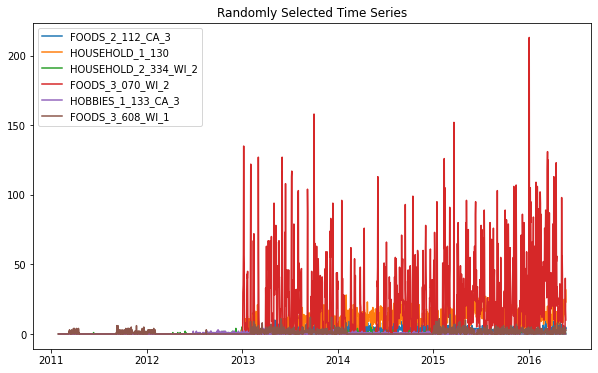

In [26]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=np.random.randint(100))
    page_labels = sample['id'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        pd.Series(series_samples.iloc[i]).astype(np.float64).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Time Series')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

In [28]:
pred_steps = 28
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

test_pred_start = last_day - pred_length + timedelta(1)
test_pred_end = last_day

val_pred_start = test_pred_start - pred_length
val_pred_end = test_pred_start - timedelta(days=1)

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

test_enc_start = val_enc_start + pred_length
test_enc_end = test_enc_start + enc_length - timedelta(1)

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end, '\n')
print('Test encoding:', test_enc_start, '-', test_enc_end)
print('Test prediction:', test_pred_start, '-', test_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2011-01-29 00:00:00 - 2016-02-28 00:00:00
Train prediction: 2016-02-29 00:00:00 - 2016-03-27 00:00:00 

Val encoding: 2011-02-26 00:00:00 - 2016-03-27 00:00:00
Val prediction: 2016-03-28 00:00:00 - 2016-04-24 00:00:00 

Test encoding: 2011-03-26 00:00:00 - 2016-04-24 00:00:00
Test prediction: 2016-04-25 00:00:00 - 2016-05-22 00:00:00

Encoding interval: 1857
Prediction interval: 28


In [29]:
n_samples = None #Set this to a finite number to train on a reduced number of samples
batch_size = 64
epochs = 5
learning_rate = 1e-3

series_array = df[df.columns[1:]].values

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, train_enc_start, train_enc_end, train_pred_start, train_pred_end, n_samples=n_samples)

callbacks = m5_helpers.make_callbacks('lstm', 'lstm_run_1')

model, dec_model, encoder_inputs, encoder_states = m5_models.create_enc_dec(learning_rate=learning_rate, hidden_size = 32, dropout = 0)


history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2,
                     callbacks=callbacks)

2022-03-23 14:23:29.564543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 14:23:31.239740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:07:00.0, compute capability: 7.5


Epoch 1/5


2022-03-23 14:23:37.696753: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


536/536 [==============================] - 44s 69ms/step - loss: 0.2523 - root_mean_squared_error: 0.5023 - val_loss: 0.2427 - val_root_mean_squared_error: 0.4926
Epoch 2/5
536/536 [==============================] - 35s 66ms/step - loss: 0.2411 - root_mean_squared_error: 0.4910 - val_loss: 0.2401 - val_root_mean_squared_error: 0.4900
Epoch 3/5
536/536 [==============================] - 36s 66ms/step - loss: 0.2389 - root_mean_squared_error: 0.4888 - val_loss: 0.2379 - val_root_mean_squared_error: 0.4878
Epoch 4/5
536/536 [==============================] - 36s 66ms/step - loss: 0.2378 - root_mean_squared_error: 0.4877 - val_loss: 0.2376 - val_root_mean_squared_error: 0.4875
Epoch 5/5
536/536 [==============================] - 36s 67ms/step - loss: 0.2370 - root_mean_squared_error: 0.4868 - val_loss: 0.2368 - val_root_mean_squared_error: 0.4867


In [30]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2,
                     callbacks=callbacks)

Epoch 1/5
536/536 [==============================] - 36s 67ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864 - val_loss: 0.2369 - val_root_mean_squared_error: 0.4867
Epoch 2/5
536/536 [==============================] - 36s 66ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861 - val_loss: 0.2361 - val_root_mean_squared_error: 0.4860
Epoch 3/5
536/536 [==============================] - 36s 67ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855 - val_loss: 0.2357 - val_root_mean_squared_error: 0.4855
Epoch 4/5
536/536 [==============================] - 36s 67ms/step - loss: 0.2353 - root_mean_squared_error: 0.4851 - val_loss: 0.2347 - val_root_mean_squared_error: 0.4845
Epoch 5/5
536/536 [==============================] - 36s 67ms/step - loss: 0.2339 - root_mean_squared_error: 0.4837 - val_loss: 0.2327 - val_root_mean_squared_error: 0.4824


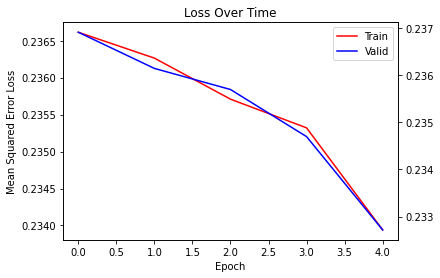

In [31]:
m5_helpers.make_training_plot(history)

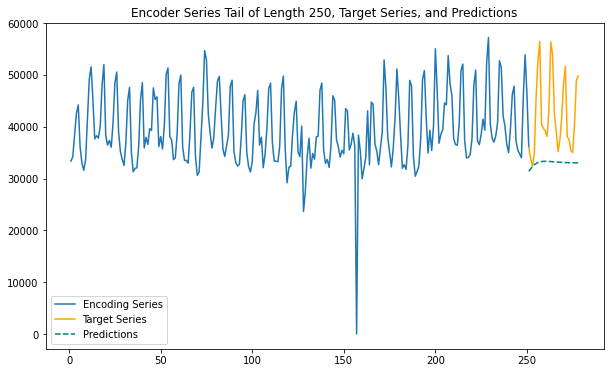

In [32]:
encoder_model = Model(encoder_inputs, encoder_states)

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_enc_start, val_enc_end, val_pred_start, val_pred_end, shuffle=False)

m5_helpers.predict_and_plot(encoder_model, encoder_input_data, decoder_target_data, encode_series_mean, sample_ind=0, enc_tail_len=250, lstm=True, dec_model=dec_model)

#### N-Beats

In [38]:
batch_size = 1024
input_steps = 28*4
pred_steps=28

val_frac=0.1
series_array = sklearn.utils.shuffle(df[df.columns[1:]].values, random_state=42) # shuffle once up front so don't have to waste time later
weights = sklearn.utils.shuffle(e.weights[0], random_state=42)
train_samples = int((1-val_frac)*series_array.shape[0])-1
val_samples = int(val_frac**series_array.shape[0])

first_valid_day = first_day + timedelta(days=input_steps)
valid_train_end_days = [first_valid_day + timedelta(days=x) for x in range((train_enc_end-first_valid_day).days + 1)]

def data_generator():
    random_start_id = np.random.choice(train_samples-batch_size-val_samples, 1)[0]
    random_train_enc_end_day = np.random.choice(valid_train_end_days, 1)[0]
    random_train_enc_start_day = random_train_enc_end_day - timedelta(days=input_steps-1)
    
    random_train_pred_start_day = random_train_enc_end_day + timedelta(days=1)
    random_train_pred_end_day = random_train_pred_start_day + timedelta(days=pred_steps) - timedelta(1)

    encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, 
                                                                                                                    random_train_enc_start_day, random_train_enc_end_day, 
                                                                                                                    random_train_pred_start_day, random_train_pred_end_day, 
                                                                                                                    shuffle=True, n_samples=train_samples)
    yield (encoder_input_data[random_start_id:random_start_id+batch_size,:,:], 
    decoder_target_data[random_start_id:random_start_id+batch_size,:,:],
    weights[random_start_id:random_start_id+batch_size])

series_array = df[df.columns[1:]].values
weights = e.weights[0]

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_pred_start - timedelta(days=input_steps), val_pred_start - timedelta(days=1), val_pred_start, val_pred_end, shuffle=False)
validation_data = (encoder_input_data, decoder_target_data, weights)
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)

In [39]:
epochs = 5
learning_rate=3e-4

callbacks = m5_helpers.make_callbacks('nbeats_model', 'nbeats_run_1')

# val_encoder_input = pd.concat([df.id, pd.DataFrame(encoder_input_data.reshape(-1,28))], axis=1, ignore_index=True)

score_cb = m5_helpers.score_callback(e=e, ids=[x+'_validation' for x in df.id], val_encoder_input=encoder_input_data, val_encode_series_mean=encode_series_mean)
callbacks.insert(0, score_cb)

shapes = ((batch_size, input_steps, 1),(batch_size, pred_steps, 1),(batch_size,))
dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.float32, tf.float32), output_shapes=shapes).repeat()

model = nbeats.NBeatsNet(backcast_length=input_steps, forecast_length=pred_steps,
                  stack_types=(nbeats.NBeatsNet.GENERIC_BLOCK, nbeats.NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=2,
                  thetas_dim=(4, 4), share_weights_in_stack=False, hidden_layer_units=8)

model.compile(Adam(learning_rate=learning_rate), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(dataset, steps_per_epoch=200, validation_data=validation_dataset, callbacks=callbacks, epochs=epochs)

NameError: name 'nbeats' is not defined

In [ ]:
m5_helpers.make_training_plot(history)

In [ ]:
encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_pred_start - timedelta(days=input_steps), val_pred_start - timedelta(days=1), val_pred_start, val_pred_end, shuffle=False)

m5_helpers.predict_and_plot(model, encoder_input_data, decoder_target_data, encode_series_mean, sample_ind=1000, enc_tail_len=input_steps, lstm=False, dec_model=None, nbeats=True)

In [ ]:
predict_batch_size = 1024
series_array = pd.read_csv(f'{m5_input_path}/sales_train_validation.csv').iloc[:,6:].values
batches = series_array.shape[0]//predict_batch_size+1
preds = []

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_pred_start - timedelta(days=input_steps), val_pred_start - timedelta(days=1), val_pred_start, val_pred_end, shuffle=False)
predictions = model.predict(encoder_input_data)

In [ ]:
predictions = m5_helpers.untransform_series_decode(predictions, encode_series_mean)
predictions = pd.DataFrame(predictions.reshape(-1,28))
predictions['id']=train_df.id
predictions = predictions[['id']+list(predictions.columns[:-1])]
predictions.columns = ['id'] + ['d_' + str(x+1886) for x in np.arange(28)]

# Score on val set
print('Score: ' + str(e.score(predictions.iloc[:,1:])))

In [ ]:
# Look at which time series are contributing to this score
print(e.contributors)

In [ ]:
import os 
os.getcwd()
path = '/ssd003/home/fahmed/forecasting-bootcamp/manulife_demos'
os.chdir()

In [ ]:
# For submission
# submitte_predictions = predictions.iloc[:,1:]
# submitte_predictions.columns = ['F'+str(x+1) for x in np.arange(28)]

# Make submissions file
sample_submission = pd.DataFrame(pd.read_csv(f'{path}/sample_submission.csv').id)
sample_submission = sample_submission.merge(predictions, on='id', how='left')
sample_submission.fillna(0, inplace=True)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

## Build aggregate dataset

In [6]:
# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % train.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, train[col].nunique()))

  unique forecasts: 30490
   N_unique item_id: 3049
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [7]:
%%time
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(train[ts_cols].sum()).transpose()
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]
all_sales

CPU times: user 125 ms, sys: 148 ms, total: 272 ms
Wall time: 267 ms


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


In [8]:
%%time
# 2. All products by state (3 series)
state_sales = train.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)
state_sales

CPU times: user 653 ms, sys: 424 ms, total: 1.08 s
Wall time: 1.07 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
1,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
2,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879


In [10]:
%%time
# 3. All products by store (10 series)
store_sales = train.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)
store_sales

CPU times: user 735 ms, sys: 1.87 s, total: 2.61 s
Wall time: 2.6 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
1,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
2,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
3,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
4,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
5,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217
6,TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,...,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974
7,WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,...,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054
8,WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,...,5317,7704,7586,5011,4628,4533,4628,4880,5213,5068
9,WI_3,4038,4198,3317,3211,2132,4590,4486,5991,4850,...,3987,5674,5894,3897,3306,3268,3398,4126,4519,4757


In [11]:
%%time
# 4. All products by category (3 series)
cat_sales = train.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)
cat_sales

CPU times: user 725 ms, sys: 279 ms, total: 1 s
Wall time: 1 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,...,30107,36576,41447,29158,26148,24790,24737,28136,33599,35967
1,HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,...,3871,4893,5016,3528,3629,3740,3475,4143,5333,5280
2,HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,...,10095,12839,13458,9676,9000,8566,8751,10273,12586,13091


In [12]:
%%time
# 5. All products by department (7 series)
dept_sales = train.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)
dept_sales

CPU times: user 722 ms, sys: 491 ms, total: 1.21 s
Wall time: 1.21 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,...,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
1,FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,...,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
2,FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,...,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
3,HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,...,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
4,HOBBIES_2,154,185,185,138,100,87,89,155,158,...,449,479,552,419,487,449,448,382,501,560
5,HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,...,7936,10042,10572,7609,6999,6641,6759,7974,9668,10165
6,HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,...,2159,2797,2886,2067,2001,1925,1992,2299,2918,2926


In [13]:
## TOP LEVEL aggregates + TOTAL
all_aggregates = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)
all_aggregates

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338
1,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
2,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
3,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879
4,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
5,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
6,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
7,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
8,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
9,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217


In [30]:
main_df = all_aggregates.set_index('id_str').T
main_df['date'] = calendar[['d', 'date']].set_index('d')['date']
main_df = main_df.set_index('date')
main_df.index = pd.DatetimeIndex(main_df.index)
main_df

id_str,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,...,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,23178,3764,5689,2343,4094,16741,3610,154,4105,1584
2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,22758,3357,5634,2216,4209,16333,3172,185,3858,1776
2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,17174,2682,3927,1657,3174,12343,2497,185,2827,1100
2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,18878,2669,3865,1508,3606,13764,2531,138,2732,1133
2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,14603,1814,2729,1209,2869,10525,1714,100,1802,927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,37096,15678,10375,11043,3995,3789,5375,2519,3147,3518,...,24790,3740,8566,3073,4648,17069,3291,449,6641,1925
2016-05-19,36963,16297,9162,11504,4136,4037,5580,2544,2748,3126,...,24737,3475,8751,3251,4551,16935,3027,448,6759,1992
2016-05-20,42552,17430,12303,12819,4433,4751,5542,2704,3664,4249,...,28136,4143,10273,3735,4815,19586,3761,382,7974,2299


# Aggregate time series visualization

Visualize data using different aggregation levels, e.g. by product category and by state. Scale the data to help vizualize differences in patterns. 

In [44]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

Text(0.5, 1.0, 'Total Sales By Product Category')

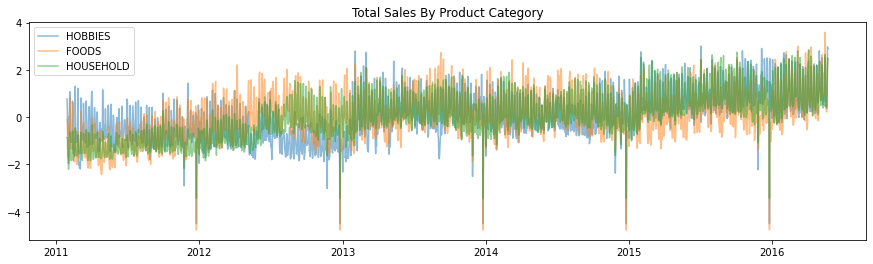

In [51]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(main_df.index, scale(main_df['HOBBIES']), label='HOBBIES', alpha=0.5)
ax.plot(main_df.index, scale(main_df['FOODS']), label='FOODS', alpha=0.5)
ax.plot(main_df.index, scale(main_df['HOUSEHOLD']), label='HOUSEHOLD', alpha=0.5)
plt.legend()
plt.title("Total Sales By Product Category")

Text(0.5, 1.0, 'Total Sales By State')

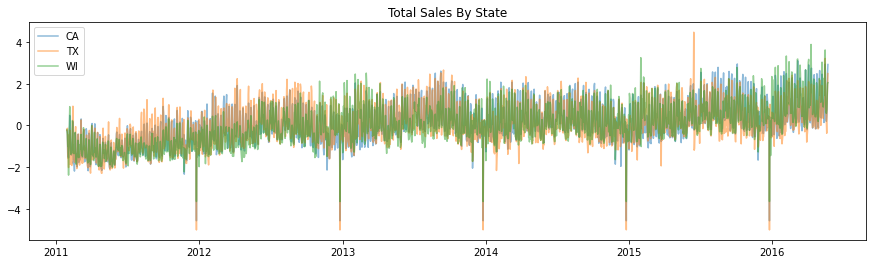

In [52]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(main_df.index, scale(main_df['CA']), label='CA', alpha=0.5)
ax.plot(main_df.index, scale(main_df['TX']), label='TX', alpha=0.5)
ax.plot(main_df.index, scale(main_df['WI']), label='WI', alpha=0.5)
plt.legend()
plt.title("Total Sales By State")

## Visualize individual product sales time series.

In [59]:
product_sales = train[ts_cols].T
product_sales['date'] = calendar[['d', 'date']].set_index('d')['date']
product_sales = product_sales.set_index('date')
product_sales.index = pd.DatetimeIndex(product_sales.index)
product_sales

id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,0,0,0,1,0,0,1,5,0,1,...,3,6,3,0,0,1,0,1,0,0
2016-05-19,3,0,2,3,0,0,0,4,0,1,...,1,4,3,1,2,0,1,0,1,2
2016-05-20,3,0,3,0,2,5,1,1,0,0,...,3,4,3,1,1,0,0,1,1,2


<AxesSubplot:xlabel='date'>

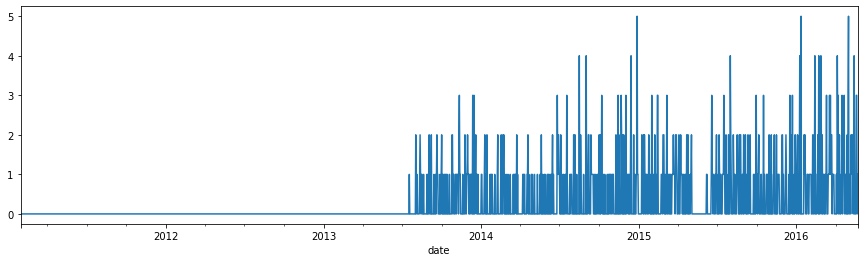

In [60]:
product_sales['HOBBIES_1_001_CA_1_evaluation'].plot(figsize=(15,4))

<AxesSubplot:xlabel='date'>

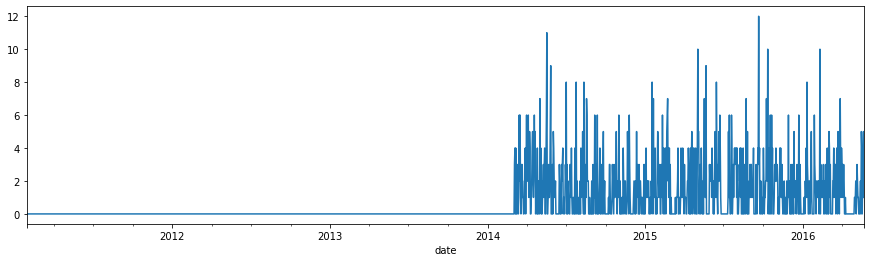

In [61]:
product_sales['FOODS_3_827_WI_3_evaluation'].plot(figsize=(15,4))